In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
import folium
import geopandas as gpd
from geopy.geocoders import Nominatim
from sklearn.cluster import DBSCAN 
import json
import re

# Preprocessing

## Data Cleaning

1. Check duplicates: None
2. Filtering
   - Drop rows where longitude/latitude cannot be impued
3. Sanity Checks
4. Imputations

In [5]:
# Dataset has mixed types
full_data = pd.read_csv("Motor_Vehicle_Collisions_-_Crashes_20240418.csv", low_memory=False, parse_dates=['CRASH DATE'])
full_data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2021-09-11,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,2022-06-29,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,2021-09-11,9:35,BROOKLYN,11208,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,2021-12-14,8:13,BROOKLYN,11233,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN


In [6]:
full_data.shape

(2081081, 29)

In [16]:
full_data.dtypes

CRASH DATE                       datetime64[ns]
CRASH TIME                               object
BOROUGH                                  object
ZIP CODE                                 object
LATITUDE                                float64
LONGITUDE                               float64
LOCATION                                 object
ON STREET NAME                           object
CROSS STREET NAME                        object
OFF STREET NAME                          object
NUMBER OF PERSONS INJURED               float64
NUMBER OF PERSONS KILLED                float64
NUMBER OF PEDESTRIANS INJURED             int64
NUMBER OF PEDESTRIANS KILLED              int64
NUMBER OF CYCLIST INJURED                 int64
NUMBER OF CYCLIST KILLED                  int64
NUMBER OF MOTORIST INJURED                int64
NUMBER OF MOTORIST KILLED                 int64
CONTRIBUTING FACTOR VEHICLE 1            object
CONTRIBUTING FACTOR VEHICLE 2            object
CONTRIBUTING FACTOR VEHICLE 3           

In [17]:
### Cleaning unexpected NaNs
for col in full_data.columns:
    if full_data[col].dtype == 'O':
        if sum(full_data[col].apply(lambda x: x.isspace() if type(x) == str else False)) > 1:
            print(col, sum(full_data[col].apply(lambda x: x.isspace() if type(x) == str else False)))
            mask = full_data[col].replace(r'^\s*$', np.nan, regex=True, inplace=False)
            print(full_data[col].isnull().sum() - mask.isnull().sum())
            full_data[col] = mask
            print(col, sum(full_data[col].apply(lambda x: x.isspace() if type(x) == str else False)))
        full_data[col] = full_data[col].str.strip()

ZIP CODE 42
-42
ZIP CODE 0
ON STREET NAME 15
-15
ON STREET NAME 0
CROSS STREET NAME 17
-17
CROSS STREET NAME 0
OFF STREET NAME 29
-29
OFF STREET NAME 0


In [18]:
for col in full_data.columns:
    print(col, ":", sum(full_data[col].isna()))
    print(sum(full_data[col].isna())*100/full_data.shape[0])

CRASH DATE : 0
0.0
CRASH TIME : 0
0.0
BOROUGH : 647518
31.114502510954644
ZIP CODE : 647811
31.128581732282406
LATITUDE : 234016
11.24492511343864
LONGITUDE : 234016
11.24492511343864
LOCATION : 234016
11.24492511343864
ON STREET NAME : 442212
21.24914887983697
CROSS STREET NAME : 787371
37.834711863690075
OFF STREET NAME : 1731286
83.19166817629876
NUMBER OF PERSONS INJURED : 18
0.000864935098633835
NUMBER OF PERSONS KILLED : 31
0.0014896104476471604
NUMBER OF PEDESTRIANS INJURED : 0
0.0
NUMBER OF PEDESTRIANS KILLED : 0
0.0
NUMBER OF CYCLIST INJURED : 0
0.0
NUMBER OF CYCLIST KILLED : 0
0.0
NUMBER OF MOTORIST INJURED : 0
0.0
NUMBER OF MOTORIST KILLED : 0
0.0
CONTRIBUTING FACTOR VEHICLE 1 : 6837
0.328531181631085
CONTRIBUTING FACTOR VEHICLE 2 : 323067
15.523999306129843
CONTRIBUTING FACTOR VEHICLE 3 : 1932289
92.85025426689302
CONTRIBUTING FACTOR VEHICLE 4 : 2047465
98.38468565135139
CONTRIBUTING FACTOR VEHICLE 5 : 2071963
99.56186232059204
COLLISION_ID : 0
0.0
VEHICLE TYPE CODE 1 : 137

In [19]:
full_data[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.847065e+06,1.847065e+06
mean,4.062739e+01,-7.375157e+01
std,1.983709e+00,3.728332e+00
min,0.000000e+00,-2.013600e+02
25%,4.066778e+01,-7.397483e+01
50%,4.072079e+01,-7.392726e+01
75%,4.076961e+01,-7.386673e+01
max,4.334444e+01,0.000000e+00


### Filter conditions

In [20]:
# filter condition 1 : longitude and latitude are 0 and no on/CROSS street name
cond = (full_data['LATITUDE'] == 0) & (full_data['LONGITUDE'] == 0) & ((full_data['ON STREET NAME'].isnull()) | full_data['CROSS STREET NAME'].isnull())

full_data[cond]['OFF STREET NAME'].isnull().sum()
print(full_data[cond].shape)
only_offstreet = full_data[cond]
data_filtered = full_data[~cond].copy()

(2030, 29)


In [21]:
# filter condition 2: longitude and latitude are nan and no/CROSS on street name
cond2 = (data_filtered['LATITUDE'].isnull()) & (data_filtered['LONGITUDE'].isnull()) & (data_filtered['ON STREET NAME'].isnull() | data_filtered['CROSS STREET NAME'].isnull())

print(data_filtered[cond2].shape)

data_filtered = data_filtered[~cond2].copy()

(93061, 29)


In [22]:
for col in data_filtered.columns:
    print(col, ":", sum(data_filtered[col].isna()))
    print(sum(data_filtered[col].isna())*100/data_filtered.shape[0])

CRASH DATE : 0
0.0
CRASH TIME : 0
0.0
BOROUGH : 560341
28.21469393098656
ZIP CODE : 560613
28.228389871046684
LATITUDE : 140955
7.097467761670502
LONGITUDE : 140955
7.097467761670502
LOCATION : 140955
7.097467761670502
ON STREET NAME : 384695
19.37043993172171
CROSS STREET NAME : 692588
34.873690199849946
OFF STREET NAME : 1663373
83.75535627067609
NUMBER OF PERSONS INJURED : 16
0.0008056435329483029
NUMBER OF PERSONS KILLED : 29
0.001460228903468799
NUMBER OF PEDESTRIANS INJURED : 0
0.0
NUMBER OF PEDESTRIANS KILLED : 0
0.0
NUMBER OF CYCLIST INJURED : 0
0.0
NUMBER OF CYCLIST KILLED : 0
0.0
NUMBER OF MOTORIST INJURED : 0
0.0
NUMBER OF MOTORIST KILLED : 0
0.0
CONTRIBUTING FACTOR VEHICLE 1 : 6624
0.3335364226405974
CONTRIBUTING FACTOR VEHICLE 2 : 309411
15.579685698316709
CONTRIBUTING FACTOR VEHICLE 3 : 1846897
92.99628900447635
CONTRIBUTING FACTOR VEHICLE 4 : 1954499
98.41434246899532
CONTRIBUTING FACTOR VEHICLE 5 : 1977372
99.56606025206572
COLLISION_ID : 0
0.0
VEHICLE TYPE CODE 1 : 134

### Imputations

In [23]:
# populate the location for rows that have on and cross but no location
df = data_filtered
temp_nm = df[df['ON STREET NAME'].notnull() & df['CROSS STREET NAME'].notnull() & df['LOCATION'].notnull()]
temp_nm = temp_nm[~temp_nm[['LOCATION', 'ON STREET NAME', 'CROSS STREET NAME']].duplicated()] # No ambiguity about location

pop_key = { (row['ON STREET NAME'], row['CROSS STREET NAME']): row['LOCATION'] for index, row in temp_nm.iterrows() }

# Use key to populate df

print("pre: ", data_filtered['LOCATION'].isnull().sum())

data_filtered['LOCATION'] = data_filtered.apply(
    lambda row: pop_key.get((row['ON STREET NAME'], row['CROSS STREET NAME'])) if pd.isna(row['LOCATION']) else row['LOCATION'], 
    axis=1
)

print("post: ", data_filtered['LOCATION'].isnull().sum())

pre:  140955
post:  30311


In [7]:
140955-30311

110644

In [24]:
print("pre 00: ", data_filtered[data_filtered['LOCATION'] == '(0.0, 0.0)'].shape[0])

data_filtered['LOCATION'] = data_filtered.apply(
    lambda row: pop_key.get((row['ON STREET NAME'], row['CROSS STREET NAME'])) if row['LOCATION'] == '(0.0, 0.0)' else row['LOCATION'], 
    axis=1
)

print("post 00: ", data_filtered[data_filtered['LOCATION'] == '(0.0, 0.0)'].shape[0])

pre 00:  9911
post 00:  8220


In [8]:
9911-8220 

1691

In [25]:
## Impute location based on place
# Isolate columns that have either location null or 0,0

data_filtered[(data_filtered['LOCATION'] == '(0.0, 0.0)') | data_filtered['LOCATION'].isnull()].shape

(38531, 29)

In [26]:
data_filtered[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.845035e+06,1.845035e+06
mean,4.067209e+01,-7.383271e+01
std,1.456494e+00,2.815063e+00
min,0.000000e+00,-2.013600e+02
25%,4.066795e+01,-7.397489e+01
50%,4.072093e+01,-7.392732e+01
75%,4.076969e+01,-7.386696e+01
max,4.334444e+01,0.000000e+00


#### Neonatim

In [27]:
geolocator = Nominatim(user_agent="geoapiVis")
location_dict = json.load(open("location_data.json"))
exception_list = json.load(open("exception_data.json"))
print(len(location_dict), len(exception_list))

3839 1735


In [28]:
data_filtered[(data_filtered['LOCATION'] == '(0.0, 0.0)') | data_filtered['LOCATION'].isnull()].shape

(38531, 29)

In [11]:
strict_lat = [40.45, 40.95]
strict_lon = [-73.65, -74.3]

In [30]:
geolocator = Nominatim(user_agent="geoapiVis")
issue = []

for idx, row in data_filtered[(data_filtered['LOCATION'] == '(0.0, 0.0)') | data_filtered['LOCATION'].isnull()].iterrows():
    if not pd.isna(row['BOROUGH']):
        place = str.lower(row['ON STREET NAME'] + " " + str(row['BOROUGH']))
    else:
        place = str.lower(row['ON STREET NAME'] + " new york")

    if (place not in location_dict.keys()) and (place not in exception_list):

        print(place)
        try:
            location = geolocator.geocode(place)
            
            if (float(location.raw['lon']) >= min(strict_lon) and float(location.raw['lon']) <= max(strict_lon) and float(location.raw['lat']) >= min(strict_lat) and float(location.raw['lat']) <= max(strict_lat)):
                location_dict[place] = location.raw
                
                print("Found")
                data_filtered.loc[idx, 'LONGITUDE'] = float(location.raw['lon'])
                data_filtered.loc[idx, 'LATITUDE'] = float(location.raw['lat'])
                data_filtered.loc[idx, 'LOCATION'] = str('('+str(location.raw['lat'])+', '+str(location.raw['lon'])+')')
        
        except Exception as e:
            print(e)
            exception_list.append(place)
            continue
    elif place in location_dict.keys():
        if not (float(location_dict[place]['lon']) >= min(strict_lon) and float(location_dict[place]['lon']) <= max(strict_lon) and float(location_dict[place]['lat']) >= min(strict_lat) and float(location_dict[place]['lat']) <= max(strict_lat)):
            print("Issue, 2", end=" ")
            issue.append(location_dict[place])
            if ', new york, ' in location_dict[place]['display_name'].lower():
                print("Issue!", location_dict[place])
            del location_dict[place]
        else:
            data_filtered.loc[idx, 'LATITUDE'] = float(location_dict[place]['lat'])
            data_filtered.loc[idx, 'LONGITUDE'] = float(location_dict[place]['lon'])
            data_filtered.loc[idx, 'LOCATION'] = str('(' + str(location_dict[place]['lat']) + ', ' + str(location_dict[place]['lon']) + ')')
    else:
        continue

broadway new york
HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=broadway+new+york&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
49 street manhattan
HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=49+street+manhattan&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
33 st queens
HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=33+st+queens&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
layton avenue new york
HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with ur

In [31]:
data_filtered[(data_filtered['LOCATION'] == '(0.0, 0.0)') | data_filtered['LOCATION'].isnull()].shape

(13748, 29)

In [33]:
data_filtered[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.869371e+06,1.869371e+06
mean,4.068262e+01,-7.385149e+01
std,1.303173e+00,2.552999e+00
min,0.000000e+00,-2.013600e+02
25%,4.066796e+01,-7.397483e+01
50%,4.072106e+01,-7.392701e+01
75%,4.077003e+01,-7.386681e+01
max,4.334444e+01,0.000000e+00


In [34]:
save_data_filtered = data_filtered.copy()

In [35]:
data_filtered = save_data_filtered.copy()

In [36]:
data_filtered[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.869371e+06,1.869371e+06
mean,4.068262e+01,-7.385149e+01
std,1.303173e+00,2.552999e+00
min,0.000000e+00,-2.013600e+02
25%,4.066796e+01,-7.397483e+01
50%,4.072106e+01,-7.392701e+01
75%,4.077003e+01,-7.386681e+01
max,4.334444e+01,0.000000e+00


In [37]:
# Serialize data into file:
json.dump( location_dict, open( "location_data.json", 'w' ) )

In [38]:
# Serialize exceptions into file
json.dump(exception_list, open("exception_data.json", 'w'))

In [39]:
print(len(location_dict), len(exception_list))

3955 2993


In [41]:
data_filtered.to_csv("Midstep.csv")

In [2]:
data_filtered = pd.read_csv("Midstep.csv", index_col=0, parse_dates=['CRASH DATE'])

In [16]:
data_filtered[['LATITUDE','LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.972091e+06,1.972091e+06
mean,4.071962e+01,-7.391788e+01
std,4.393646e-01,1.228438e+00
min,0.000000e+00,-2.013600e+02
25%,4.066839e+01,-7.397466e+01
50%,4.072117e+01,-7.392612e+01
75%,4.076998e+01,-7.386540e+01
max,4.334444e+01,0.000000e+00


In [10]:
data_filtered.iloc[71677]

CRASH DATE                                       2021-08-07 00:00:00
CRASH TIME                                                     20:50
BOROUGH                                                     BROOKLYN
ZIP CODE                                                     11207.0
LATITUDE                                                   40.675495
LONGITUDE                                                  -73.88916
LOCATION                                      (40.675495, -73.88916)
ON STREET NAME                                        LIBERTY AVENUE
CROSS STREET NAME                                     SCHENCK AVENUE
OFF STREET NAME                                                  NaN
NUMBER OF PERSONS INJURED                                        0.0
NUMBER OF PERSONS KILLED                                         0.0
NUMBER OF PEDESTRIANS INJURED                                      0
NUMBER OF PEDESTRIANS KILLED                                       0
NUMBER OF CYCLIST INJURED         

In [17]:
# Back populate longitude and latitude

print("pre: ", data_filtered['LONGITUDE'].isnull().sum(), data_filtered['LATITUDE'].isnull().sum())


for idx, row in data_filtered[(data_filtered['LONGITUDE'].isna() | data_filtered['LONGITUDE'] == 0) & (data_filtered['LOCATION'].notna())].iterrows():
    if row['LOCATION']:
        try:
            lat, lon = row['LOCATION'].strip('()').split(",")
        
            # Check if valid
            if (float(lat) >= min(strict_lat) and float(lat) <= max(strict_lat) and float(lon) >= min(strict_lon) and float(lon) <= max(strict_lon)):
                # now, replace
                data_filtered.loc[idx, 'LATITUDE'] = float(lat)
                data_filtered.loc[idx, 'LONGITUDE'] = float(lon)
        
            elif  (float(lon) >= min(strict_lat) and float(lon) <= max(strict_lat) and float(lat) >= min(strict_lon) and float(lat) <= max(strict_lon)):
                # now, replace
                print("Opp", end=" ")
                data_filtered.loc[idx, 'LATITUDE'] = float(lat)
                data_filtered.loc[idx, 'LONGITUDE'] = float(lon)
        except Exception as e:
            print(e, row['LOCATION'])
            print(idx)
            break
print("post: ", data_filtered['LONGITUDE'].isnull().sum(), data_filtered['LATITUDE'].isnull().sum())

pre:  13899 13899
post:  13899 13899


In [14]:
print("pre 00: ", data_filtered[data_filtered['LONGITUDE'] == 0].shape[0], data_filtered[data_filtered['LATITUDE'] == 0].shape[0])

for idx, row in data_filtered[(data_filtered['LONGITUDE'] == 0)].iterrows():
    if row['LOCATION']:
        lat, lon = row['LOCATION'].strip('()').split(",")
    
        # Check if valid
        if (float(lat) >= min(strict_lat) and float(lat) <= max(strict_lat) and float(lon) >= min(strict_lon) and float(lon) <= max(strict_lon)):
            # now, replace
            data_filtered.loc[idx, 'LATITUDE'] = float(lat)
            data_filtered.loc[idx, 'LONGITUDE'] = float(lon)
    
        elif  (float(lon) >= min(strict_lat) and float(lon) <= max(strict_lat) and float(lat) >= min(strict_lon) and float(lat) <= max(strict_lon)):
            # now, replace
            print("Opp", end=" ")
            data_filtered.loc[idx, 'LATITUDE'] = float(lat)
            data_filtered.loc[idx, 'LONGITUDE'] = float(lon)

print("post 00: ", data_filtered[data_filtered['LONGITUDE'] == 0].shape[0], data_filtered[data_filtered['LATITUDE'] == 0].shape[0])

pre 00:  218 218
post 00:  218 218


In [ ]:
print(data_filtered[(data_filtered['LOCATION'].isnull() | (data_filtered['LOCATION'] == '(0.0, 0.0)'))].shape)

In [ ]:
for col in data_filtered.columns:
    print(col, ":", sum(data_filtered[col].isna()))
    print(sum(data_filtered[col].isna())*100/data_filtered.shape[0])

In [ ]:
data_filtered[['LATITUDE', 'LONGITUDE']].describe()

In [75]:
data_filtered.to_csv("After_API.csv")

In [18]:
data_filtered = pd.read_csv("After_API.csv", index_col=0)

In [19]:
strict_lat = [40.492009391283906,40.950900568005]
strict_lon = [-74.5633786294863,-73.65616396303963]

In [20]:
print(data_filtered.shape)
data_filtered[['LATITUDE', 'LONGITUDE']].describe()

(1985990, 29)


,LATITUDE,LONGITUDE
count,1.972091e+06,1.972091e+06
mean,4.071962e+01,-7.391788e+01
std,4.393646e-01,1.228438e+00
min,0.000000e+00,-2.013600e+02
25%,4.066839e+01,-7.397466e+01
50%,4.072117e+01,-7.392612e+01
75%,4.076998e+01,-7.386540e+01
max,4.334444e+01,0.000000e+00


In [22]:
data__strict_filtered = data_filtered[(data_filtered['LATITUDE']>=min(strict_lat)) & (data_filtered['LATITUDE']<=max(strict_lat)) & (data_filtered['LONGITUDE']>=min(strict_lon)) & (data_filtered['LONGITUDE']<=max(strict_lon))]
print(data_filtered.shape, data__strict_filtered.shape)

(1985990, 29) (1971716, 29)


In [23]:
### FILTER data that still does not have a location
print(data__strict_filtered[(data__strict_filtered['LOCATION'].isnull() | (data__strict_filtered['LOCATION'] == '(0.0, 0.0)'))].shape)
data_zip = data__strict_filtered[~(data__strict_filtered['LOCATION'].isnull() | (data__strict_filtered['LOCATION'] == '(0.0, 0.0)'))]
print(data_zip.shape)

(0, 29)
(1971716, 29)


In [24]:
data_zip[['LONGITUDE', 'LATITUDE']].describe()

,LONGITUDE,LATITUDE
count,1.971716e+06,1.971716e+06
mean,-7.391970e+01,4.072420e+01
std,8.724767e-02,7.931909e-02
min,-7.425496e+01,4.049895e+01
25%,-7.397466e+01,4.066842e+01
50%,-7.392614e+01,4.072117e+01
75%,-7.386541e+01,4.076999e+01
max,-7.365788e+01,4.094956e+01


In [26]:
data_zip.to_csv("Midstep.csv")

#### Zipcode

In [25]:
pattern = r"^\(\-?\d+.\d*, -?\d+.\d*\)$"
mask = ~data_zip['LOCATION'].str.match(pattern, na=False)
# Everyone matches our string
sum(mask)

0

In [27]:
# Group by latitude and longitude and aggregate zipcode
data_zip_group = data_zip.groupby(['LOCATION'])['ZIP CODE'].agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0  else None)

In [28]:
cleaned_zip_data = data_zip.copy()
cleaned_zip_data[cleaned_zip_data['ZIP CODE'].isna()].shape

(548028, 29)

In [29]:
zip_dict = json.load(open("zip_dictionary.json"))
count = 0
nd_count = 0

pattern_zip = re.compile(r'\b\d{5}\b')

for idx, row in cleaned_zip_data[cleaned_zip_data['ZIP CODE'].isna()].iterrows():
    done = False
    if (row['LOCATION'] in data_zip_group.index) and (data_zip_group[row['LOCATION']] is not None):
        # Impute with value
        cleaned_zip_data.loc[idx, 'ZIP CODE'] = data_zip_group[row['LOCATION']]
        done = True
    elif row['LOCATION'] in zip_dict.keys():
        # Already looked up
        cleaned_zip_data.loc[idx, 'ZIP CODE'] = zip_dict[row['LOCATION']]
        done = True
    else:
        try:
            # Check with location_dict
            if not pd.isna(row['BOROUGH']):
                place = str.lower(row['ON STREET NAME'] + " " + str(row['BOROUGH']))
            else:
                place = str.lower(row['ON STREET NAME'] + " new york")
    
            if place in location_dict.keys():
                match = pattern_zip.search(location_dict[place]['display_name'])
                if match:
                    cleaned_zip_data.loc[idx, 'ZIP CODE'] = match.group()
                    done = True
        except Exception as e:
            print(e, "Could not build place")

    if not done:
        ## not a match, reverse lookup
        try:
            location = geolocator.reverse({row['LATITUDE'], row['LONGITUDE']}, addressdetails=True)
            post = location.raw['address']['postcode']
            cleaned_zip_data.loc[idx, 'ZIP CODE'] = post
            zip_dict[row['LOCATION']] = post
            done = True
            count += 1
        except Exception as e:
            print(e, "Error imputing post")
    if not done:
        nd_count += 1

print("count", count)
print("Not done", nd_count)

count 0
Not done 0


In [30]:
cleaned_zip_data[cleaned_zip_data['ZIP CODE'].isna()].shape

(316467, 29)

In [31]:
cleaned_zip_data[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.971716e+06,1.971716e+06
mean,4.072420e+01,-7.391970e+01
std,7.931909e-02,8.724767e-02
min,4.049895e+01,-7.425496e+01
25%,4.066842e+01,-7.397466e+01
50%,4.072117e+01,-7.392614e+01
75%,4.076999e+01,-7.386541e+01
max,4.094956e+01,-7.365788e+01


In [32]:
print(len(zip_dict), cleaned_zip_data['ZIP CODE'].isnull().sum())

0 316467


In [33]:
len(json.load(open("zip_dictionary.json")))

0

In [34]:
json.dump(zip_dict, open( "zip_dictionary.json", 'w' ) )

In [35]:
cleaned_zip_data.isna().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           547756
ZIP CODE                          316467
LATITUDE                               0
LONGITUDE                              0
LOCATION                               0
ON STREET NAME                    384686
CROSS STREET NAME                 692439
OFF STREET NAME                  1649105
NUMBER OF PERSONS INJURED             16
NUMBER OF PERSONS KILLED              29
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6583
CONTRIBUTING FACTOR VEHICLE 2     307483
CONTRIBUTING FACTOR VEHICLE 3    1833398
CONTRIBUTING FACTOR VEHICLE 4    1940381
CONTRIBUTING FACTOR VEHICLE 5    1963140
COLLISION_ID                           0
VEHICLE TYPE COD

In [36]:
cleaned_zip_data.to_csv("Midstep.csv")

#### Finding number of persons killed

In [37]:
cleaned_zip_data['NUMBER OF PERSONS INJURED'] = cleaned_zip_data.apply(lambda row: row['NUMBER OF PEDESTRIANS INJURED'] + row['NUMBER OF CYCLIST INJURED'] + row['NUMBER OF MOTORIST INJURED']  if pd.isna(row['NUMBER OF PERSONS INJURED']) else row['NUMBER OF PERSONS INJURED'], axis=1)
cleaned_zip_data['NUMBER OF PERSONS KILLED'] = cleaned_zip_data.apply(lambda row: row['NUMBER OF PEDESTRIANS KILLED'] + row['NUMBER OF CYCLIST KILLED'] + row['NUMBER OF MOTORIST KILLED']  if pd.isna(row['NUMBER OF PERSONS KILLED']) else row['NUMBER OF PERSONS KILLED'], axis=1)

In [38]:
for col in cleaned_zip_data.columns:
    print(col, ":", sum(cleaned_zip_data[col].isna()))
    print(sum(cleaned_zip_data[col].isna())*100/data_filtered.shape[0])

CRASH DATE : 0
0.0
CRASH TIME : 0
0.0
BOROUGH : 547756
27.58100493960191
ZIP CODE : 316467
15.93497449634691
LATITUDE : 0
0.0
LONGITUDE : 0
0.0
LOCATION : 0
0.0
ON STREET NAME : 384686
19.36998675723443
CROSS STREET NAME : 692439
34.86618764444937
OFF STREET NAME : 1649105
83.03692365016944
NUMBER OF PERSONS INJURED : 0
0.0
NUMBER OF PERSONS KILLED : 0
0.0
NUMBER OF PEDESTRIANS INJURED : 0
0.0
NUMBER OF PEDESTRIANS KILLED : 0
0.0
NUMBER OF CYCLIST INJURED : 0
0.0
NUMBER OF CYCLIST KILLED : 0
0.0
NUMBER OF MOTORIST INJURED : 0
0.0
NUMBER OF MOTORIST KILLED : 0
0.0
CONTRIBUTING FACTOR VEHICLE 1 : 6583
0.33147196108741733
CONTRIBUTING FACTOR VEHICLE 2 : 307483
15.482605652596439
CONTRIBUTING FACTOR VEHICLE 3 : 1833398
92.31657762627204
CONTRIBUTING FACTOR VEHICLE 4 : 1940381
97.70346275661005
CONTRIBUTING FACTOR VEHICLE 5 : 1963140
98.8494403295082
COLLISION_ID : 0
0.0
VEHICLE TYPE CODE 1 : 13339
0.6716549428748383
VEHICLE TYPE CODE 2 : 380397
19.154023937683473
VEHICLE TYPE CODE 3 : 1838

### Sanity checks

In [39]:
Checks = {
    'Manhattan': (data_filtered['ZIP CODE'] >= 10001) & (data_filtered['ZIP CODE'] <= 10282),
    'Staten Island': (data_filtered['ZIP CODE'] >= 10301) & (data_filtered['ZIP CODE'] <= 10314),
    'Bronx': (data_filtered['ZIP CODE'] >= 10451) & (data_filtered['ZIP CODE'] <= 10475),
    'Queens': ((data_filtered['ZIP CODE'] >= 11004) & (data_filtered['ZIP CODE'] <= 11109)) | ((data_filtered['ZIP CODE'] >= 11351) & (data_filtered['ZIP CODE'] <= 11697)),
    'Brooklyn': (data_filtered['ZIP CODE'] >= 11201) & (data_filtered['ZIP CODE'] <= 11256)
}

for key,value in Checks.items():
    issues = data_filtered[value & ~(data_filtered['BOROUGH']==str.capitalize(key))]
    print(issues.shape)

(318845, 29)
(59711, 29)
(210442, 29)
(380934, 29)
(454410, 29)


In [40]:
318845/ cleaned_zip_data.shape[0], 59711/cleaned_zip_data.shape[0], 210442/cleaned_zip_data.shape[0], 380934/ cleaned_zip_data.shape[0], 454410/cleaned_zip_data.shape[0]

(0.16170939425353348,
 0.030283773119455338,
 0.10673038104879201,
 0.1931992234175713,
 0.23046422507095343)

In [41]:
saved_cleaned_zip_data = cleaned_zip_data.copy()

In [42]:
Checks = {
    'MANHATTAN': (cleaned_zip_data['ZIP CODE'] >= 10001) & (cleaned_zip_data['ZIP CODE'] <= 10282),
    'STATEN ISLAND': (cleaned_zip_data['ZIP CODE'] >= 10301) & (cleaned_zip_data['ZIP CODE'] <= 10314),
    'BRONX': (cleaned_zip_data['ZIP CODE'] >= 10451) & (cleaned_zip_data['ZIP CODE'] <= 10475),
    'QUEENS': ((cleaned_zip_data['ZIP CODE'] >= 11004) & (cleaned_zip_data['ZIP CODE'] <= 11109)) | ((cleaned_zip_data['ZIP CODE'] >= 11351) & (cleaned_zip_data['ZIP CODE'] <= 11697)),
    'BROOKLYN': (cleaned_zip_data['ZIP CODE'] >= 11201.0) & (cleaned_zip_data['ZIP CODE'] <= 11256.0)
}

for key,value in Checks.items():
    issues = cleaned_zip_data[value & ~(cleaned_zip_data['BOROUGH']==key)]
    print(key, ": ", issues.shape[0]*100/ cleaned_zip_data.shape[0])
    if issues.shape[0] > 0:
        cleaned_zip_data.loc[value, 'BOROUGH'] = key
        issues = cleaned_zip_data[value & ~(cleaned_zip_data['BOROUGH']==key)]
        print("After cleaning: ", issues.shape[0]*100/ cleaned_zip_data.shape[0])

MANHATTAN :  2.653120429108452
After cleaning:  0.0
STATEN ISLAND :  0.5522600617938892
After cleaning:  0.0
BRONX :  1.719720284260005
After cleaning:  0.0
QUEENS :  3.1103363770441583
After cleaning:  0.0
BROOKLYN :  3.732535517285451
After cleaning:  0.0


In [43]:
for col in cleaned_zip_data.columns:
    print(col, ":", sum(cleaned_zip_data[col].isna()))
    print(sum(cleaned_zip_data[col].isna())*100/cleaned_zip_data.shape[0])

CRASH DATE : 0
0.0
CRASH TIME : 0
0.0
BOROUGH : 316327
16.043233406839523
ZIP CODE : 316467
16.050333820895098
LATITUDE : 0
0.0
LONGITUDE : 0
0.0
LOCATION : 0
0.0
ON STREET NAME : 384686
19.51021343844651
CROSS STREET NAME : 692439
35.118597201625384
OFF STREET NAME : 1649105
83.63805943655171
NUMBER OF PERSONS INJURED : 0
0.0
NUMBER OF PERSONS KILLED : 0
0.0
NUMBER OF PEDESTRIANS INJURED : 0
0.0
NUMBER OF PEDESTRIANS KILLED : 0
0.0
NUMBER OF CYCLIST INJURED : 0
0.0
NUMBER OF CYCLIST KILLED : 0
0.0
NUMBER OF MOTORIST INJURED : 0
0.0
NUMBER OF MOTORIST KILLED : 0
0.0
CONTRIBUTING FACTOR VEHICLE 1 : 6583
0.33387161234173685
CONTRIBUTING FACTOR VEHICLE 2 : 307483
15.594690107500268
CONTRIBUTING FACTOR VEHICLE 3 : 1833398
92.98489234757947
CONTRIBUTING FACTOR VEHICLE 4 : 1940381
98.41077518263279
CONTRIBUTING FACTOR VEHICLE 5 : 1963140
99.56504892185285
COLLISION_ID : 0
0.0
VEHICLE TYPE CODE 1 : 13339
0.6765173077664329
VEHICLE TYPE CODE 2 : 380397
19.29268718212968
VEHICLE TYPE CODE 3 : 1

In [44]:
cleaned_zip_data[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.971716e+06,1.971716e+06
mean,4.072420e+01,-7.391970e+01
std,7.931909e-02,8.724767e-02
min,4.049895e+01,-7.425496e+01
25%,4.066842e+01,-7.397466e+01
50%,4.072117e+01,-7.392614e+01
75%,4.076999e+01,-7.386541e+01
max,4.094956e+01,-7.365788e+01


In [45]:
cleaned_zip_data.to_csv("Cleaned_Data.csv")

### Clean rows where more other injuries/deaths than persons injures/deaths

In [47]:
cleaned_data = pd.read_csv("Cleaned_Data.csv", index_col=0, parse_dates=['CRASH DATE'])

In [48]:
print(cleaned_data[(cleaned_data['NUMBER OF PERSONS KILLED'] ==0)& ((cleaned_data['NUMBER OF MOTORIST KILLED'] > 0)|(cleaned_data['NUMBER OF CYCLIST KILLED'] > 0) | (cleaned_data['NUMBER OF PEDESTRIANS KILLED'] > 0))].shape)
print(cleaned_data[(cleaned_data['NUMBER OF PERSONS INJURED'] == 0)& ((cleaned_data['NUMBER OF MOTORIST INJURED'] > 0)|(cleaned_data['NUMBER OF CYCLIST INJURED'] > 0) | (cleaned_data['NUMBER OF PEDESTRIANS INJURED'] > 0))].shape)

(4, 29)
(165, 29)


In [49]:
for idx, row in cleaned_data[(cleaned_data['NUMBER OF PERSONS KILLED'] ==0)& ((cleaned_data['NUMBER OF MOTORIST KILLED'] > 0)|(cleaned_data['NUMBER OF CYCLIST KILLED'] > 0) | (cleaned_data['NUMBER OF PEDESTRIANS KILLED'] > 0))].iterrows():
    cleaned_data.loc[idx, 'NUMBER OF PERSONS KILLED'] = row['NUMBER OF CYCLIST KILLED'] + row['NUMBER OF PEDESTRIANS KILLED'] + row['NUMBER OF MOTORIST KILLED']

print(cleaned_data[(cleaned_data['NUMBER OF PERSONS KILLED'] ==0)& ((cleaned_data['NUMBER OF MOTORIST KILLED'] > 0)|(cleaned_data['NUMBER OF CYCLIST KILLED'] > 0) | (cleaned_data['NUMBER OF PEDESTRIANS KILLED'] > 0))].shape)

(0, 29)


In [50]:
for idx, row in cleaned_data[(cleaned_data['NUMBER OF PERSONS INJURED'] ==0)& ((cleaned_data['NUMBER OF MOTORIST INJURED'] > 0)|(cleaned_data['NUMBER OF CYCLIST INJURED'] > 0) | (cleaned_data['NUMBER OF PEDESTRIANS INJURED'] > 0))].iterrows():
    cleaned_data.loc[idx, 'NUMBER OF PERSONS INJURED'] = row['NUMBER OF CYCLIST INJURED'] + row['NUMBER OF PEDESTRIANS INJURED'] + row['NUMBER OF MOTORIST INJURED']

print(cleaned_data[(cleaned_data['NUMBER OF PERSONS INJURED'] ==0)& ((cleaned_data['NUMBER OF MOTORIST INJURED'] > 0)|(cleaned_data['NUMBER OF CYCLIST INJURED'] > 0) | (cleaned_data['NUMBER OF PEDESTRIANS INJURED'] > 0))].shape)

(0, 29)


In [51]:
cleaned_data[['LATITUDE', 'LONGITUDE']].describe()

,LATITUDE,LONGITUDE
count,1.971716e+06,1.971716e+06
mean,4.072420e+01,-7.391970e+01
std,7.931909e-02,8.724767e-02
min,4.049895e+01,-7.425496e+01
25%,4.066842e+01,-7.397466e+01
50%,4.072117e+01,-7.392614e+01
75%,4.076999e+01,-7.386541e+01
max,4.094956e+01,-7.365788e+01


In [52]:
cleaned_data.to_csv("Cleaned_Data.csv")

In [53]:
data = pd.read_csv("Cleaned_Data.csv", index_col = 0, parse_dates=['CRASH DATE'])
data.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2021-09-11,2:39,QUEENS,11104.0,40.674000,-73.872100,"(40.674, -73.8721)",WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
3,2021-09-11,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,2021-12-14,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN
6,2021-12-14,17:05,NaN,NaN,40.709183,-73.956825,"(40.709183, -73.956825)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4486555,Sedan,Tractor Truck Diesel,NaN,NaN,NaN
7,2021-12-14,8:17,BRONX,10475.0,40.868160,-73.831480,"(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,Unspecified,NaN,NaN,NaN,4486660,Sedan,Sedan,NaN,NaN,NaN


In [55]:
data['YEAR'] = data['CRASH DATE'].dt.year

In [56]:
for year in data['YEAR'].unique():
    yr_data = data[data['YEAR']==year]
    yr_data.to_csv("Cleaned Data/Cleaned_for_"+str(year)+".csv")

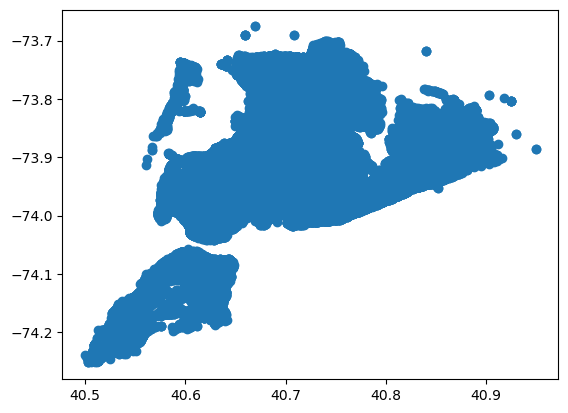

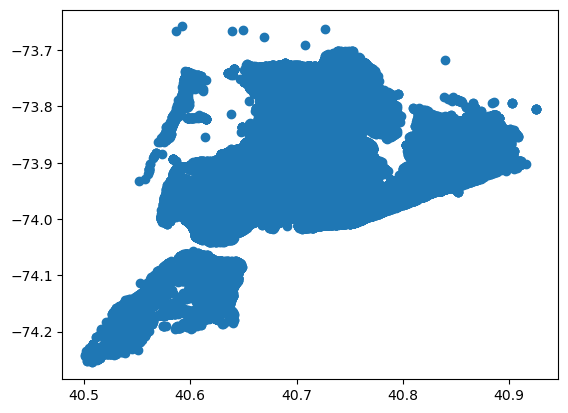

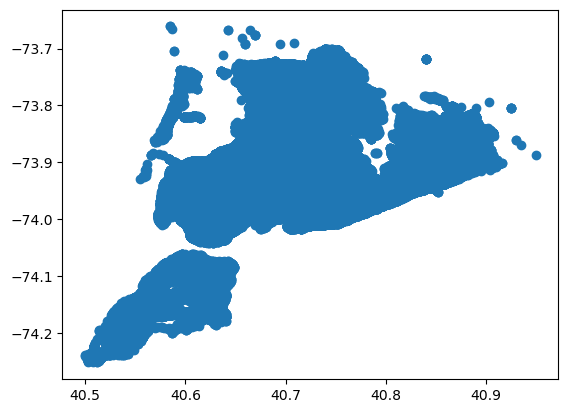

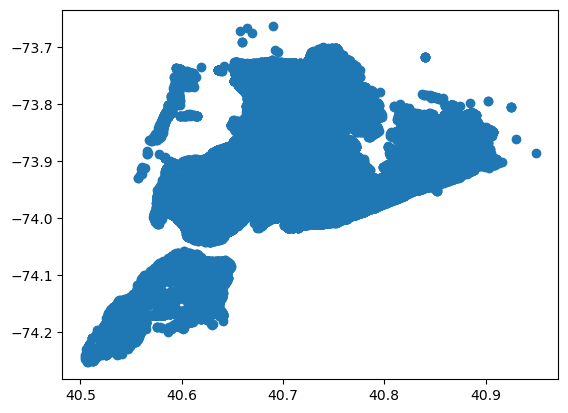

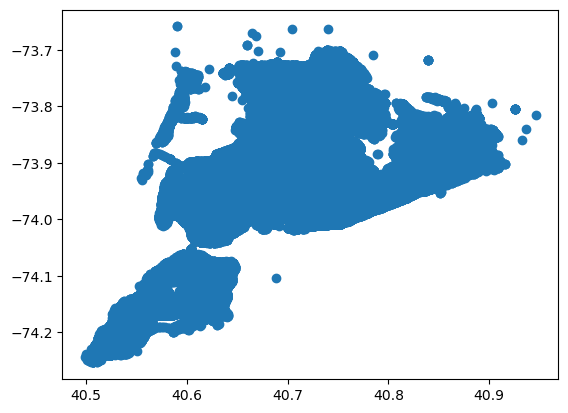

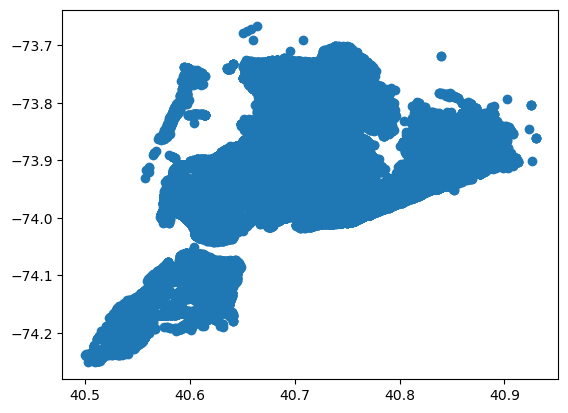

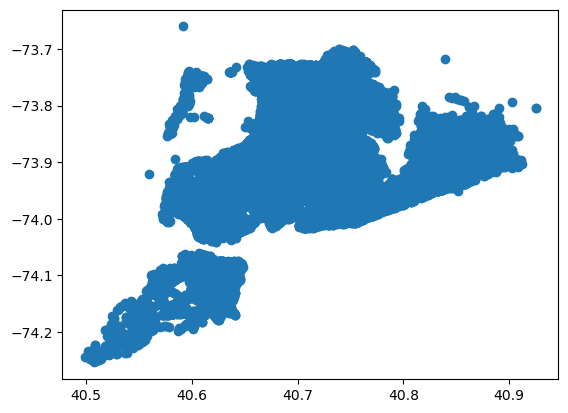

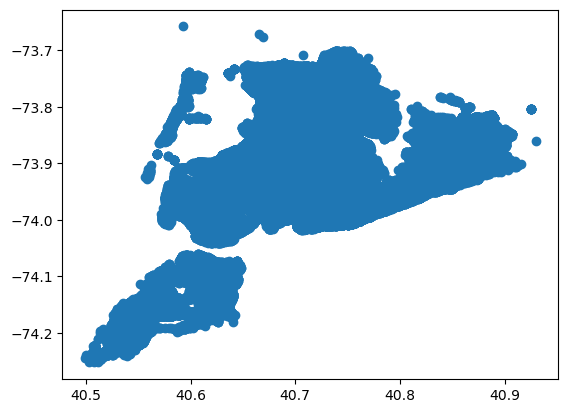

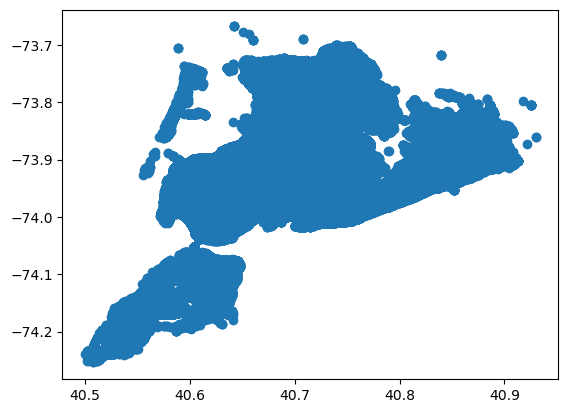

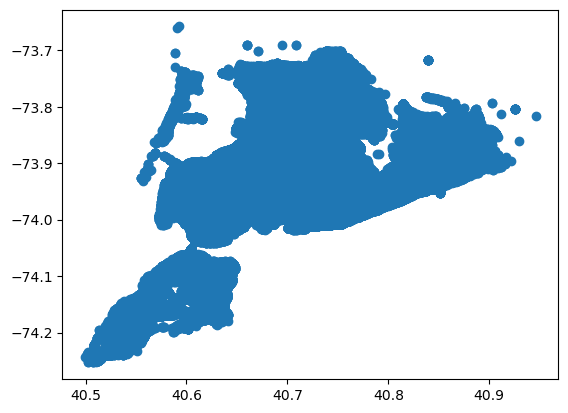

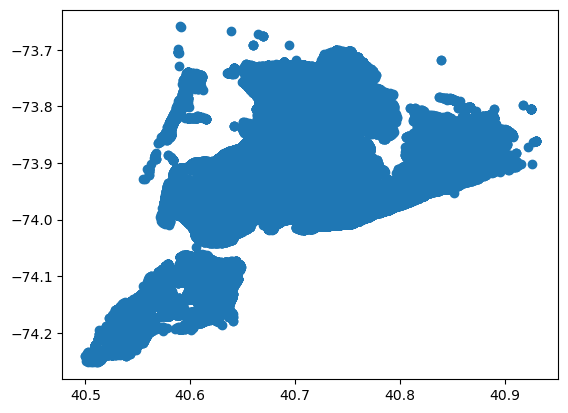

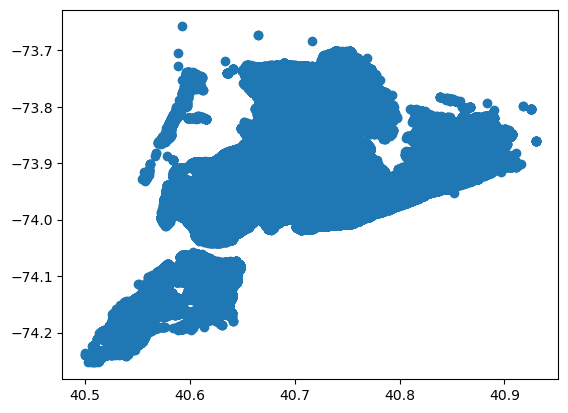

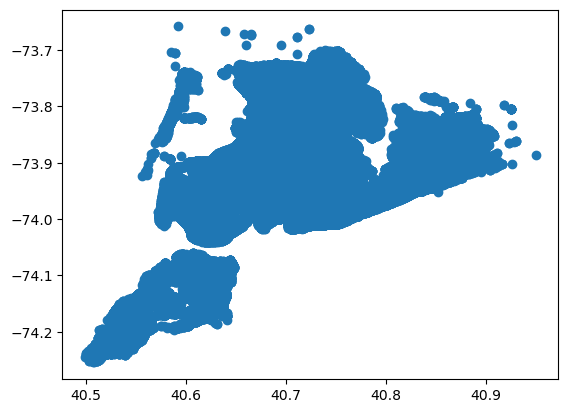

In [59]:
for year in data['YEAR'].unique():
    yr_data = data[data['YEAR']==year]
    plt.scatter(yr_data['LATITUDE'], yr_data['LONGITUDE'])
    plt.show()